In [152]:
import pickle
import gzip
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os
import numpy as np
np.random.seed(666)

from tensorflow import set_random_seed
set_random_seed(125)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
import keras

from keras.layers import Conv2D,MaxPooling2D,Flatten
from sklearn.externals import joblib



In [175]:
def accuracy(test_data,test_target,model):
    correct = 0
    predicted = model.predict(test_data,verbose=True)
    left = np.array(np.argmax(predicted,axis=1)).flatten()
    right = np.argmax(test_target,axis=1)
    confusion_mat = np.zeros((len(np.unique(right)),len(np.unique(left))))
    for i in range(len(test_target)):
        if(left[i] == right[i]):
            correct+=1
        confusion_mat[left[i]][right[i]] =confusion_mat[left[i]][right[i]] +1
    return correct/len(test_target),pd.DataFrame(np.matrix(confusion_mat,dtype="int32"))

def more_metrics(conf_mat):
    true_positives = 0
    precision = []
    recall = []
    for i in range(len(conf_mat)):
        true_positives += conf_mat.iloc[i,i]
    conf_mat = np.matrix(conf_mat)
    tp_fp = np.array(np.sum(conf_mat,axis=1)).ravel()
    relevant_elements = np.array(np.sum(conf_mat,axis=0)).ravel()
    for i in range(len(conf_mat)):
        precision.append(conf_mat[i,i]/tp_fp[i])
        recall.append(conf_mat[i,i]/relevant_elements[i])
    return true_positives,precision,recall

In [104]:
filename = '../mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()
train_data = np.append(training_data[0],validation_data[0],axis=0)
train_target = np.append(training_data[1],validation_data[1],axis=0)
train_target = keras.utils.to_categorical(train_target, 10)
test_target = keras.utils.to_categorical(test_data[1], 10)
test_data = test_data[0]

In [106]:
image_vector_size = 28* 28
train_data = train_data.reshape(train_data.shape[0], image_vector_size)
test_data = test_data.reshape(test_data.shape[0], image_vector_size)


In [23]:
def baseline():
    model = Sequential()
    model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

def highHidden():
    drop_out = 0.1
    model = Sequential()
    model.add(Dense(units=32,activation='sigmoid',input_shape=(image_vector_size,)))
    model.add(Activation('tanh'))
    model.add(Dense(128, input_dim=image_vector_size))
    model.add(Activation('relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(128, input_dim=image_vector_size))
    model.add(Dense(units=num_classes, activation='softmax'))

    #sgd = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])    
    model.summary()
    return model

def lowHidden():
    model = Sequential()
    model.add(Dense(units=1024,activation='tanh',input_shape=(image_vector_size,)))
    model.add(Dense(2048,activation='relu',input_dim=image_vector_size))
    model.add(Dense(units=num_classes, activation='softmax'))

    #sgd = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])    
    model.summary()
    return model

def conv():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1),activation='tanh',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [108]:
model = lowHidden()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                20490     
Total params: 2,923,530
Trainable params: 2,923,530
Non-trainable params: 0
_________________________________________________________________


In [122]:
NNType = 'DNN'

if(NNType=='CNN'):
    print("Processing for CNN")
    filename = '../mnist.pkl.gz'
    f = gzip.open(filename, 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    num_classes = 10

    x_train = np.append(training_data[0],validation_data[0],axis=0)
    y_train = np.append(training_data[1],validation_data[1])
    x_test = test_data[0]
    y_test = test_data[1]

    img_x, img_y = 28, 28
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
    x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
    input_shape = (img_x, img_y, 1)

    # convert the data to the right type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    #print('x_train shape:', x_train.shape)
    #print(x_train.shape[0], 'train samples')
    #print(x_test.shape[0], 'test samples')

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, 
                                 patience=20, mode='auto')
    history = model.fit(x_train, y_train, 
                        batch_size=128,
                        epochs=150,
                        verbose=True,
                        validation_split=.1,
                        callbacks = [earlystopping_cb])

In [190]:
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, 
                                 patience=5, mode='auto')

history = model.fit(train_data, train_target, 
                    batch_size=128, 
                    epochs=150,
                    verbose=True,
                    validation_split=.1,
                   callbacks = [earlystopping_cb])

Train on 54000 samples, validate on 6000 samples
Epoch 1/150
54000/54000 [==============================] - 12s 222us/step - loss: 0.0092 - acc: 0.9987 - val_loss: 0.2045 - val_acc: 0.9823
Epoch 2/150
54000/54000 [==============================] - 12s 222us/step - loss: 0.0140 - acc: 0.9982 - val_loss: 0.1782 - val_acc: 0.9838
Epoch 3/150
54000/54000 [==============================] - 12s 223us/step - loss: 0.0086 - acc: 0.9986 - val_loss: 0.1735 - val_acc: 0.9853
Epoch 4/150
54000/54000 [==============================] - 12s 222us/step - loss: 0.0064 - acc: 0.9991 - val_loss: 0.1687 - val_acc: 0.9852
Epoch 5/150
54000/54000 [==============================] - 12s 222us/step - loss: 0.0123 - acc: 0.9985 - val_loss: 0.2013 - val_acc: 0.9825
Epoch 6/150
54000/54000 [==============================] - 12s 222us/step - loss: 0.0099 - acc: 0.9986 - val_loss: 0.1704 - val_acc: 0.9862
Epoch 7/150
54000/54000 [==============================] - 12s 222us/step - loss: 0.0114 - acc: 0.9985 - val_lo

In [191]:
loss,acc = model.evaluate(train_data, train_target, verbose=True)
print("The Loss for Training is: "+str(loss))
print("The Accuracy for Training is: "+str(acc))

60000/60000 [==============================] - 6s 93us/step
The Loss for Training is: 0.024260458143711427
The Accuracy for Training is: 0.9977333333333334


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6cab6655f8>,
      dtype=object)

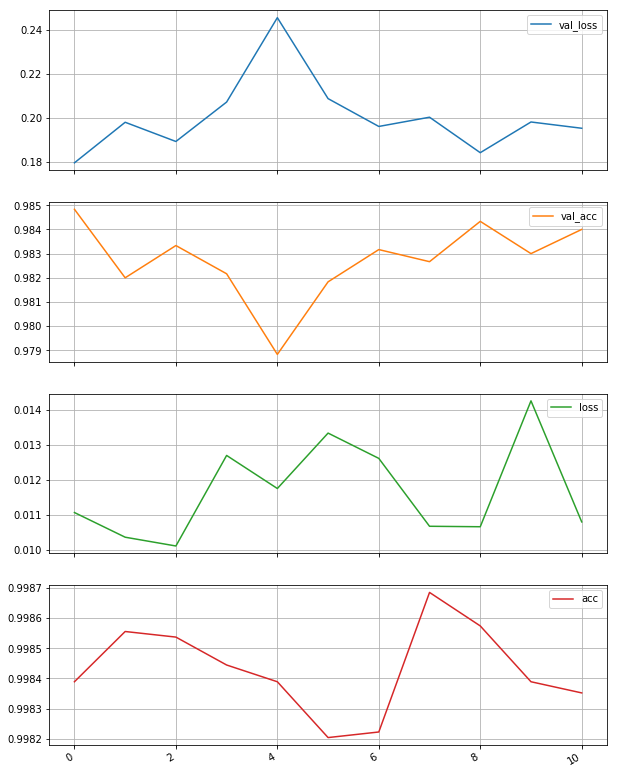

In [187]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [158]:
#joblib.dump(model,'./models/DNN_lowHidden.joblib',compress=True)
#model = joblib.load('./models/DNN_lowHidden.joblib')

# Pre Process USPS

In [162]:
USPSMat  = []
USPSTar  = []
curPath  = '../USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

In [163]:
if(NNType =='CNN'):
    print("Processing for CNN")
    USPSMat  = []
    USPSTar  = []
    curPath  = '../USPSdata/Numerals'
    savedImg = []

    for j in range(0,10):
        curFolderPath = curPath + '/' + str(j)
        imgs =  os.listdir(curFolderPath)
        for img in imgs:
            curImg = curFolderPath + '/' + img
            if curImg[-3:] == 'png':
                img = Image.open(curImg,'r')
                img = img.resize((28, 28))
                img = np.asarray(img)
                #savedImg = img
                #imgdata = (255-np.array(img.getdata()))/255
                USPSMat.append(img)
                USPSTar.append(j)
    USPSMat = np.asarray(USPSMat)
    USPSMat = USPSMat.reshape(USPSMat.shape[0], 28, 28, 1)

In [164]:
USPSTar = keras.utils.to_categorical(USPSTar, num_classes)

In [188]:
acc,conf_mat = accuracy(test_data,test_target,model)
print("The Accuracy for Testing on MNIST is: "+str(acc))
print("The Confusion Matrix is: ")
print(conf_mat)
_,precision,recall = more_metrics(pd.DataFrame(conf_mat))
print("The Precision & Recall is: ")
df = pd.DataFrame(np.multiply(precision,100))
df.columns = ["Precision"]
df1 = pd.DataFrame(np.multiply(recall,100))
df1.columns = ["Recall"]
print(pd.concat([df,df1],axis=1))

10000/10000 [==============================] - 1s 87us/step
The Accuracy for Testing on MNIST is: 0.985
The Confusion Matrix is: 
     0     1     2    3    4    5    6     7    8    9
0  971     0     1    1    1    2    3     0    1    0
1    0  1130     0    0    0    1    2     4    0    2
2    1     2  1024    6    2    0    1     8    3    1
3    2     1     0  992    1   13    1     1    6    3
4    1     0     0    0  968    1    1     1    1   10
5    0     0     0    3    1  868    2     0    2    4
6    3     1     0    0    1    4  948     0    2    0
7    0     0     5    2    1    1    0  1009    2    2
8    1     1     2    2    1    1    0     1  954    1
9    1     0     0    4    6    1    0     4    3  986
The Precision & Recall is: 
   Precision     Recall
0  99.081633  99.081633
1  99.209833  99.559471
2  97.709924  99.224806
3  97.254902  98.217822
4  98.474059  98.574338
5  98.636364  97.309417
6  98.852972  98.956159
7  98.727984  98.151751
8  98.962656  97.9466

In [189]:
acc,conf_mat = accuracy([USPSMat],USPSTar,model)
print("The Accuracy for Testing on USPS is: "+str(acc))
print("The Confusion Matrix is: ")
print(conf_mat)
_,precision,recall = more_metrics(pd.DataFrame(conf_mat))
print("The Precision & Recall is: ")
df = pd.DataFrame(np.multiply(precision,100))
df.columns = ["Precision"]
df1 = pd.DataFrame(np.multiply(recall,100))
df1.columns = ["Recall"]
print(pd.concat([df,df1],axis=1))

19999/19999 [==============================] - 2s 87us/step
The Accuracy for Testing on USPS is: 0.5105255262763139
The Confusion Matrix is: 
     0    1     2     3     4     5     6    7    8    9
0  684   31    29     7    10    40    97   22  137    8
1    4  686     8     6   102     2     8  197    6  102
2  174  287  1705   117    69   150   351  357  185  157
3  133  150    86  1651    40   133   102  541  417  440
4  280  237    15     6  1222    11    69   35   90  159
5  179   48    49   166   111  1563   203   26  341   39
6   85   77    38     6    30     6  1035   15   67    8
7  145  356    35    16   191    22    29  723   57  502
8   22   57    30    22   184    63    37   78  666  310
9  294   71     4     3    41    10    69    6   34  275
The Precision & Recall is: 
   Precision     Recall
0  64.225352  34.200000
1  61.195361  34.300000
2  48.001126  85.292646
3  44.706201  82.550000
4  57.532957  61.100000
5  57.357798  78.150000
6  75.713241  51.750000
7  34.82659

In [ ]:
model.predict([USPSMat],verbose=True)